In [1]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.8 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
import numpy as np

<ipython-input-2-476a4bb66000>:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [3]:
# Define the model-building function
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(hp.Int('units_1', min_value=16, max_value=128, step=16), (3,3), activation='relu', input_shape=(28,28,1)))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(hp.Int('units_2', min_value=32, max_value=256, step=32), (3,3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(hp.Int('units_3', min_value=32, max_value=256, step=32), (3,3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [4]:
# prepare the data

(x_train,y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

11490434/11490434 [==============================] - 0s 0us/step


In [5]:
# Instantiate a RandomSearch tuner object
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='my_dir',
    project_name='my_project')

In [6]:
# Search for the best hyperparameters
tuner.search(x_train, y_train, epochs=10, validation_split=0.1, use_multiprocessing=True)

Trial 10 Complete [00h 02m 23s]
val_accuracy: 0.9804999828338623

Best val_accuracy So Far: 0.9933333396911621
Total elapsed time: 00h 18m 58s


In [8]:
# Print the best hyperparameters and their corresponding accuracy score
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f'Best hyperparameters: {best_hps.values}')
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=10, validation_split=0.1, use_multiprocessing=True)

Best hyperparameters: {'units_1': 16, 'units_2': 96, 'units_3': 256, 'dropout': 0.30000000000000004, 'learning_rate': 0.001}
Epoch 1/10
1688/1688 [==============================] - 10s 5ms/step - loss: 0.1441 - accuracy: 0.9543 - val_loss: 0.0431 - val_accuracy: 0.9882
Epoch 2/10
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0485 - accuracy: 0.9848 - val_loss: 0.0360 - val_accuracy: 0.9902
Epoch 3/10
1688/1688 [==============================] - 11s 7ms/step - loss: 0.0342 - accuracy: 0.9891 - val_loss: 0.0305 - val_accuracy: 0.9920
Epoch 4/10
1688/1688 [==============================] - 12s 7ms/step - loss: 0.0269 - accuracy: 0.9913 - val_loss: 0.0310 - val_accuracy: 0.9922
Epoch 5/10
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0208 - accuracy: 0.9932 - val_loss: 0.0331 - val_accuracy: 0.9927
Epoch 6/10
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0178 - accuracy: 0.9943 - val_loss: 0.0283 - val_accuracy: 0.9932
Epoch 7/

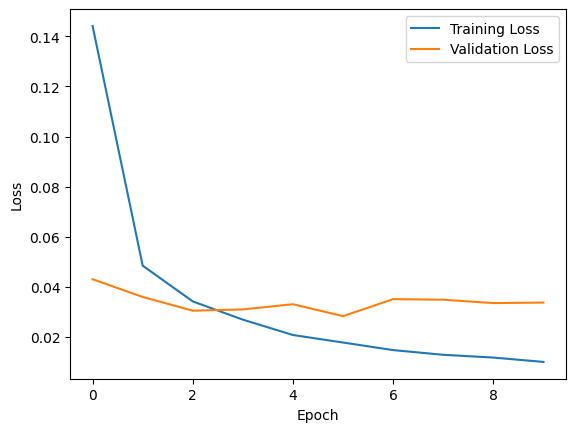

In [9]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
import matplotlib.pyplot as plt
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()